In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, mode
from math import sqrt
import time 
import numpy as np
import matplotlib.animation as animation
%matplotlib notebook
from scipy import signal
import math
import scipy.optimize as optimize
import scipy.io as sio
import scipy.signal as signal
import itertools
from scipy.fftpack import fft, ifft
plt.style.use('seaborn')
import pickle
from scipy import stats
from zebra_chord import *
from collect_statistics import *
from visualization import *
from mpl_toolkits.mplot3d import Axes3D
import scipy

#### First task figure out a numerical integration scheme for the readout   
* Completed I use an approximation of the dirac delta function which can be numerically integrated
#### Find the list of parameters that gives a nice readout pattern 

* The individual oscillation period of the cells i.e. the period of w 
* The collective oscillation period of the entire organism after delayed coupling or coupling
* The length of the somites that I am getting by following this method and the number of cells in each somite  
* How is the readout related to the length of the somites  
* Need the physical meaning of some of the parameters and the feasible values thats missing right now 

All the above values can be found in the literature  
This further will tell me if the parameters that I am using are correct or not 
#### Characterise the readout pattern using some kind of methodology and make statements about patterns etc  
* One way is to collect statistics about the rmax and rmin and the oscillation thresholds  
* Another way would be the statistics on somites 
* Autocorrelation and PSD are some of the other methods 

In [5]:
dic = return_default_dic()
dic["v_0"] = .25
dic["dt"] = 0.5
dic["n_t"]  = 200
dic["n_c"] = 50
dic["dx"] = 0.75
dic["delay"] = 11
dic["tau_d"] = round(dic["delay"]/dic["dt"])
dic["u_0"] = .5
dic["c"] = 20
dic["tau_w"] = 1.
dic["gamma1"] = 21
dic["tau_c"] = 0
dic["tau_2"] = 20
dic["beta"] = 0.1
dic["n"] = 4
dic["m"] = 5
dic["K_u"] = 0.3
dic["loc"] = 40
dic["sigma_1"] = 0.0026 ## std deviation of the white noise added
dic["sigma_2"] = 0.0026 ## std deviation of the white noise added


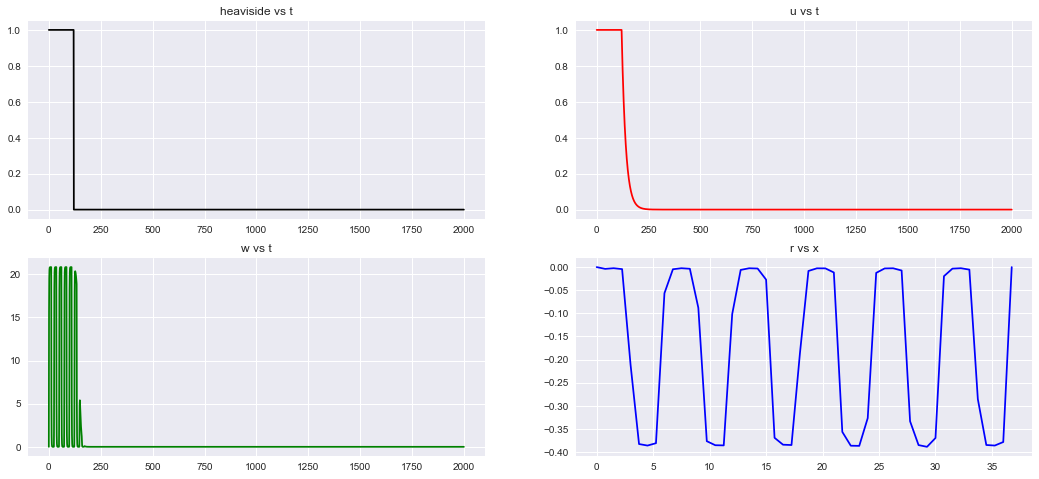

In [6]:
u, w, r, h, t, x = run_sim_(dic, coupling= False, noise = True,plot = True, plot_r = False, plot_mollifier=False)



In [204]:
loc  = 30
clip_signal = 250
by = 3

#### Q1 - Check that noisy and uncoupled joint(w_max and w_min) and joint(t_max and t_min) follow a normal distribution
as postulated in Jose et. al. paper 

In [26]:
def downsample_array(a, by):
    return a[::by]

In [27]:
w_d  = downsample_array(w[loc][:clip_signal], by)
t_d = downsample_array(t[:clip_signal], by)

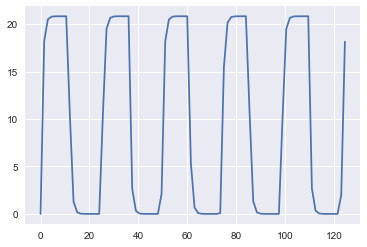

In [28]:
plt.plot(t_d, w_d)

In [29]:
w_max, w_min, t_max, t_min, peaks = get_oscillations_of_w_single_cell(w_d, t_d)

w_j = list(np.concatenate((w_max, w_min), axis = 0))
t_j = list(np.concatenate((t_max, t_min), axis = 0))

k, p_w, a_ = normal_test(w_j)
k, p_t, a_ = normal_test(t_j)

null hypothesis: data comes from a normal distribution
The null hypothesis cannot be rejected
null hypothesis: data comes from a normal distribution
The null hypothesis cannot be rejected


/anaconda3/envs/rem/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/anaconda3/envs/rem/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


#### Verified 

#### Plot of the snr and cv of u, w and r as the noise in increased from 0 to 0.6 1000 timepoints

In [205]:
noise  = np.linspace(0, 1, 500)


In [206]:
u_snr_cv = []
w_snr_cv = []
r_snr_cv = []
u_list = []
w_list = []
r_list = []
for i, n in enumerate(noise):
    dic["sigma_1"] = n
    dic["sigma_2"] = n
    u, w, r, h, t, x = run_sim_(dic, coupling= False, noise = True, plot = False, plot_r = False, plot_mollifier=False)
    u_list.append(u)
    w_list.append(w)
    r_list.append(r)
    u_snr_cv.append((return_snr_mean_to_std(u[loc]), return_CV(u[loc])))
    w_snr_cv.append((return_snr_mean_to_std(w[loc]), return_CV(w[loc])))
    r_snr_cv.append((return_snr_mean_to_std(r), return_CV(r)))

In [207]:
#pickle.dump([u_list, w_list, r_list], open("data_uncoupled_noisy.pkl", "wb"))

In [208]:
data = pickle.load(open("data_uncoupled_noisy.pkl", "rb"))

In [209]:
u_list, w_list, r_list = data

In [210]:
def get_qf_list(sig_list, cell_loc, type_method):
    if cell_loc == None:
        r_list = sig_list
    else:
        r_list = (np.asarray(sig_list)[:, cell_loc, :])
    qf_W = []
    print (r_list.shape)
    for w in r_list:
        sample_signal = w
        if(type_method=="linear_interp"):
            qf = compute_qf_linear_interp(sample_signal)
        else:
            qf = curve_intersection_qf(sample_signal)
        qf_W.append(qf)
    return qf_W

def compute_qf_linear_interp(sig):
    freq, psd = scipy.signal.welch(sig)
    psd = 10*np.log10(psd)
    sig_max = np.amax(psd)
    y_line = sig_max - 3
    ind_g = np.where(psd > y_line)
    ind_l = np.where(psd < y_line)
    val_g = psd[ind_g]
    val_l = psd[ind_l]

    y_max = np.amax(val_g)
    y_2_max = np.amax(val_l)
    f_2_max = freq[np.where(psd == y_2_max)]
    f_max = freq[np.argmax(psd)]

    f_x = (f_max - f_2_max)*(y_line - y_max)/(y_max - y_2_max) + f_2_max

    qf = f_max/(2*(f_max - f_x))[0]
    return qf
def curve_intersection_qf(signal):
    freq, psd = scipy.signal.welch(signal)
    psd = 10*np.log10(psd)
    sig_max = np.amax(psd)
    y_line = sig_max - 3
    idx = np.argwhere(np.diff(np.sign(psd - y_line))).flatten()
    f_max = freq[np.argmax(psd)]
    freq_id = freq[idx[1]]
    return (f_max/2*(f_max-freq_id))

In [211]:
qf_W = get_qf_list(w_list, 30, "linear_interp")

(500, 4000)


In [1]:
plt.plot(noise, qf_W)

NameError: name 'plt' is not defined

In [214]:
def plot_psd(sig, size_tup, type_plot, plot_cutoff=False):
    freq, psd = scipy.signal.welch(sig)
    fig, ax = plt.subplots(figsize=size_tup)
    psd = 10*np.log10(psd)
    ymax = np.amax(psd)
    if (plot_cutoff):
        ax.plot(freq,[ymax-3 for i in range(len(freq))])
    
    ax.set_ylabel("PSD")
    ax.set_xlabel("freq")
    if (type_plot=="line"):
        ax.plot(freq, psd)
    elif (type_plot=="scatter"):
        ax.scatter(freq, psd)
    else:
        ax.plot(freq, psd)
        ax.scatter(freq, psd)
    return fig, ax
        


1.6577061314625994

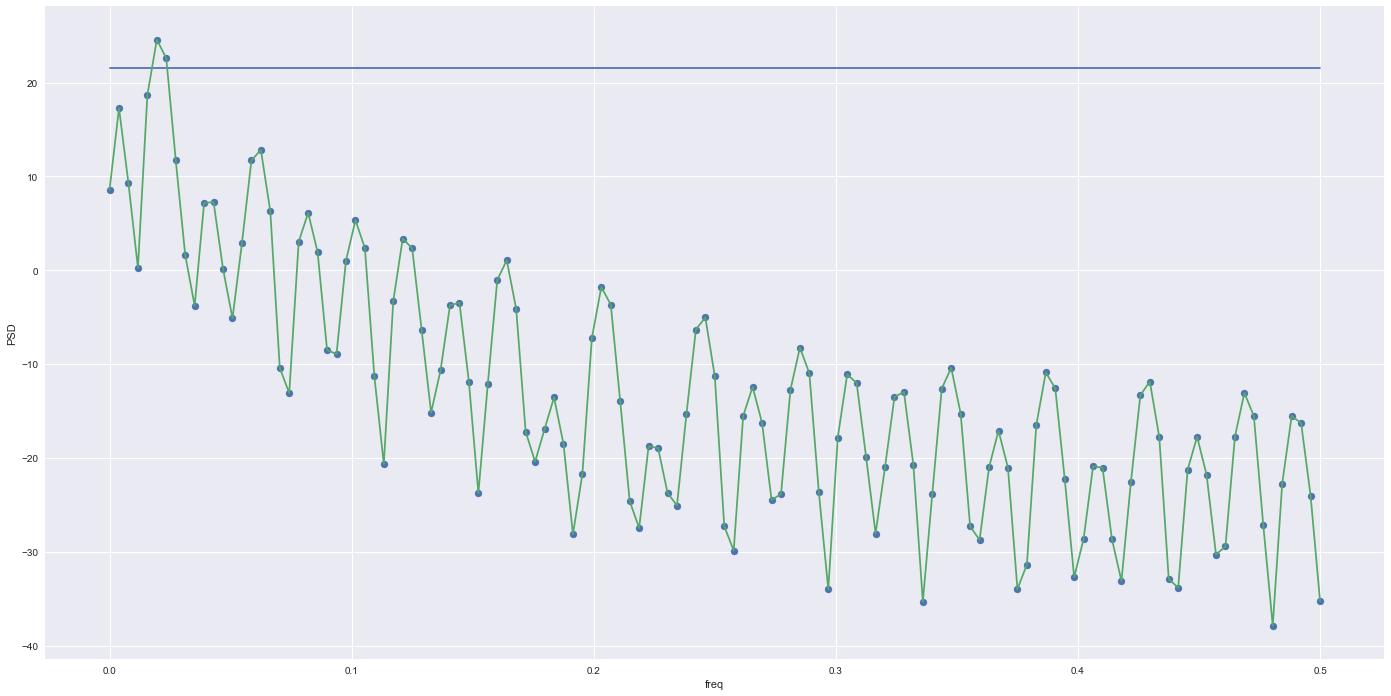

In [216]:

_, ax = plot_psd(w_list[3][20], (24, 12), "both", plot_cutoff=True)
qf_l = compute_qf_linear_interp(w_list[3][20])
qf_l

23.73397053489595 0.5
[4 6]


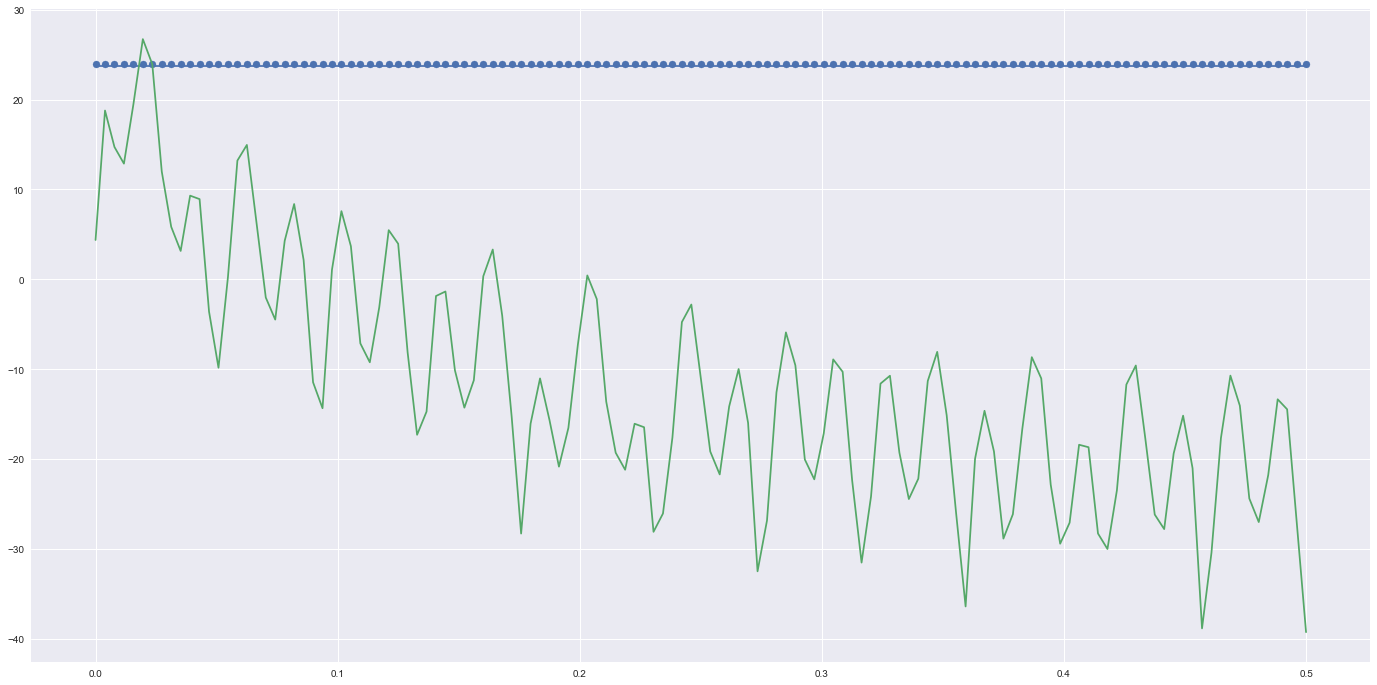

In [175]:

freq, psd = scipy.signal.welch(w_list[9][30])
psd = 10*np.log10(psd)
sig_max = np.amax(psd)
y_line = sig_max - 3
val = np.interp(y_line, psd, freq)
print (y_line, val)
plt.figure(figsize=(24, 12))
plt.plot(freq,[y_line for i in range(len(freq))])
#plt.plot(freq,[val for i in range(len(freq))])
#plt.scatter(freq,[y_2_max for i in range(len(freq))])
#plt.scatter(freq,[y_max for i in range(len(freq))])
#plt.scatter([f_x for i in range(len(freq))], psd)
#plt.scatter(freq,[psd[idx[0]] for i in range(len(freq))])


    
plt.scatter(freq,[psd[idx[1]] for i in range(len(freq))])

plt.plot(freq, psd)
print (idx)
#plt.scatter(freq, psd)
#plt.scatter(freq, top)
#plt.plot(freq, p_val)

In [110]:
p = np.polyfit(freq, psd, 500)
pp = np.poly1d(p)
p_val = [pp(f) for f in freq]

/anaconda3/envs/rem/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


How i am calculating QF of signal :   
    compute the squared absolute value of the fft of the signal  
    compute the freqs of the fft   
    plot freq vs spectrum  
    detect the max of the signal  
    take a 3db window on either side of the signal  
    take ratio of the max frq to 2 times the 3db window 
    
    

In [32]:
def return_snr_cv(li):
    snr,cv = [], []
    for l in li:
        snr.append(l[0])
        cv.append(abs(l[1]))
    return snr, cv

###### snr and cv plots of u

In [33]:
u_snr, u_cv  = return_snr_cv(u_snr_cv)

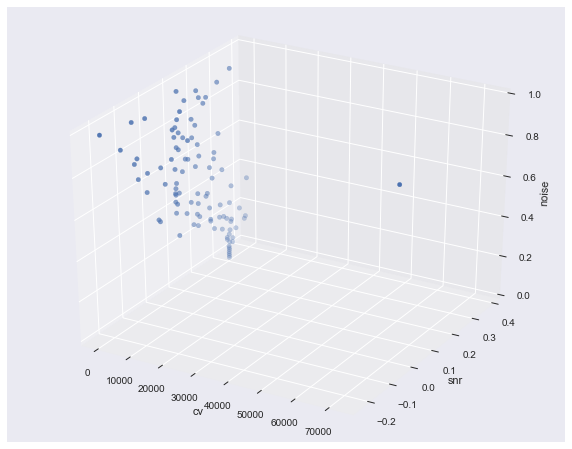

In [34]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(0, 1)
ax.set_xlabel("cv")
ax.set_ylabel("snr")
ax.set_zlabel("noise")
ax.scatter(u_cv, u_snr, noise)

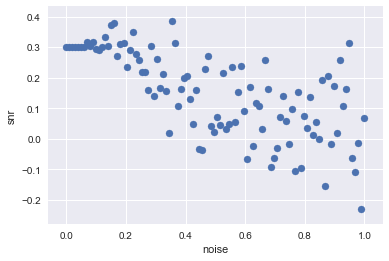

In [35]:
plt.xlabel("noise")
plt.ylabel("snr")
plt.scatter(noise, u_snr)

###### snr and cv plots of w

In [36]:
w_snr, w_cv  = return_snr_cv(w_snr_cv)

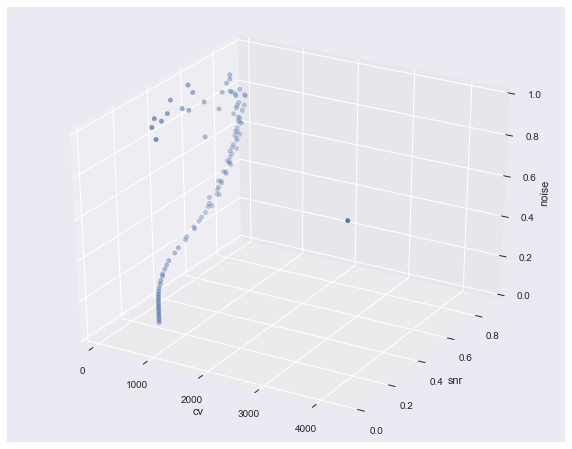

In [37]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(0, 1)
ax.set_xlabel("cv")
ax.set_ylabel("snr")
ax.set_zlabel("noise")
ax.scatter(w_cv, w_snr, noise)

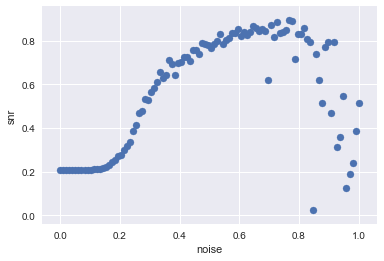

In [38]:
plt.xlabel("noise")
plt.ylabel("snr")
plt.scatter(noise, w_snr)

###### snr and cv plots of r

In [39]:
r_snr, r_cv  = return_snr_cv(r_snr_cv)

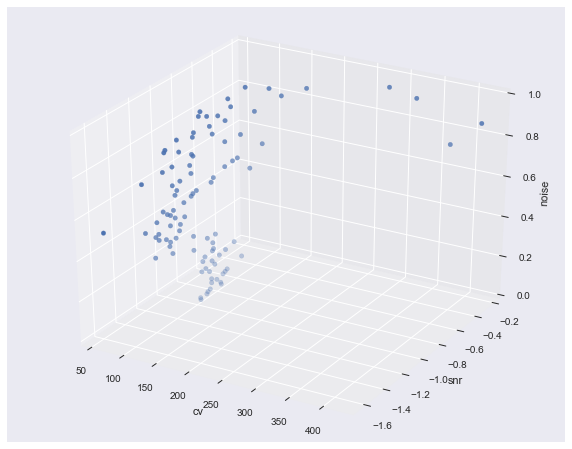

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(0, 1)
ax.set_xlabel("cv")
ax.set_ylabel("snr")
ax.set_zlabel("noise")
ax.scatter(r_cv, r_snr, noise)

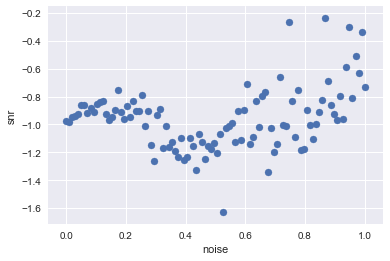

In [41]:
plt.xlabel("noise")
plt.ylabel("snr")
plt.scatter(noise, r_snr)

##### How the somite size distribution changes upon addition of noise but no coupling

In [42]:
stat_list = []
peaks_list = []
dist_list = []
for ri in r_list:
    statistics, peaks, dist = extract_somite_statistics_from_readout(ri, dic["dx"])
    stat_list.append(statistics)
    peaks_list.append(peaks)
    dist_list.append(dist)

In [45]:
(stat_list[0])

(array([1.5, 6. , 7.5]), array([1, 8, 1]))

In [49]:
def get_viable_somites_percentage_in_readout(stat):
    size, number = stat[0], stat[1]
    """
    viable somites are the ones with length between 6 and 8
    """
    viable = 0
    for i, s in enumerate(size):
        if (s>= 6 and s<= 8):
            viable = viable+number[i]
    return(100*viable/sum(number))

In [50]:
viable_somite_percentage_list = []
for ss in stat_list:
    viable_somite_percentage_list.append(get_viable_somites_percentage_in_readout(ss))

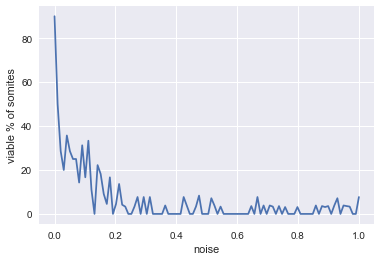

In [51]:
plt.xlabel("noise")
plt.ylabel("viable % of somites")
plt.plot(noise, viable_somite_percentage_list)


We see that the percentage of viable somites drops upon addition of noise, we next investigate whether increasing the coupling strength stabilises the somite size 

In [67]:
beta = np.linspace(0, 1, 100)
noise  = np.linspace(0, 1, 100)


In [68]:
u_snr_cv = []
w_snr_cv = []
r_snr_cv = []
u_list = []
w_list = []
r_list = []
for i, n in enumerate(noise):
    dic["sigma_1"] = n
    dic["sigma_2"] = n
    dic["beta"] = beta[i]
    u, w, r, h, t, x = run_sim_(dic, coupling= True, noise = True, plot = False, plot_r = False, plot_mollifier=False)
    u_list.append(u)
    w_list.append(w)
    r_list.append(r)
    u_snr_cv.append((return_snr_mean_to_std(u[loc]), return_CV(u[loc])))
    w_snr_cv.append((return_snr_mean_to_std(w[loc]), return_CV(w[loc])))
    r_snr_cv.append((return_snr_mean_to_std(r), return_CV(r)))

In [69]:
pickle.dump([u_list, w_list, r_list], open("data_coupled_noisy.pkl", "wb"))

In [73]:
stat_list = []
peaks_list = []
dist_list = []
for i, ri in enumerate(r_list):
    try:
        statistics, peaks, dist = extract_somite_statistics_from_readout(ri, dic["dx"])
        stat_list.append(statistics)
        peaks_list.append(peaks)
        dist_list.append(dist)
    except:
        print(i, beta[i])

69 0.696969696969697
70 0.7070707070707072
71 0.7171717171717172
72 0.7272727272727273
73 0.7373737373737375
74 0.7474747474747475
75 0.7575757575757577
76 0.7676767676767677
77 0.7777777777777778
78 0.787878787878788
79 0.797979797979798
80 0.8080808080808082
81 0.8181818181818182
82 0.8282828282828284
83 0.8383838383838385
84 0.8484848484848485
85 0.8585858585858587
86 0.8686868686868687
87 0.8787878787878789
88 0.888888888888889
89 0.8989898989898991
90 0.9090909090909092
91 0.9191919191919192
92 0.9292929292929294
93 0.9393939393939394
94 0.9494949494949496
95 0.9595959595959597
96 0.9696969696969697
97 0.9797979797979799
98 0.98989898989899
99 1.0


In [74]:
viable_somite_percentage_list = []
for ss in stat_list[:69]:
    viable_somite_percentage_list.append(get_viable_somites_percentage_in_readout(ss))

In [80]:
%matplotlib qt

<IPython.core.display.Javascript object>


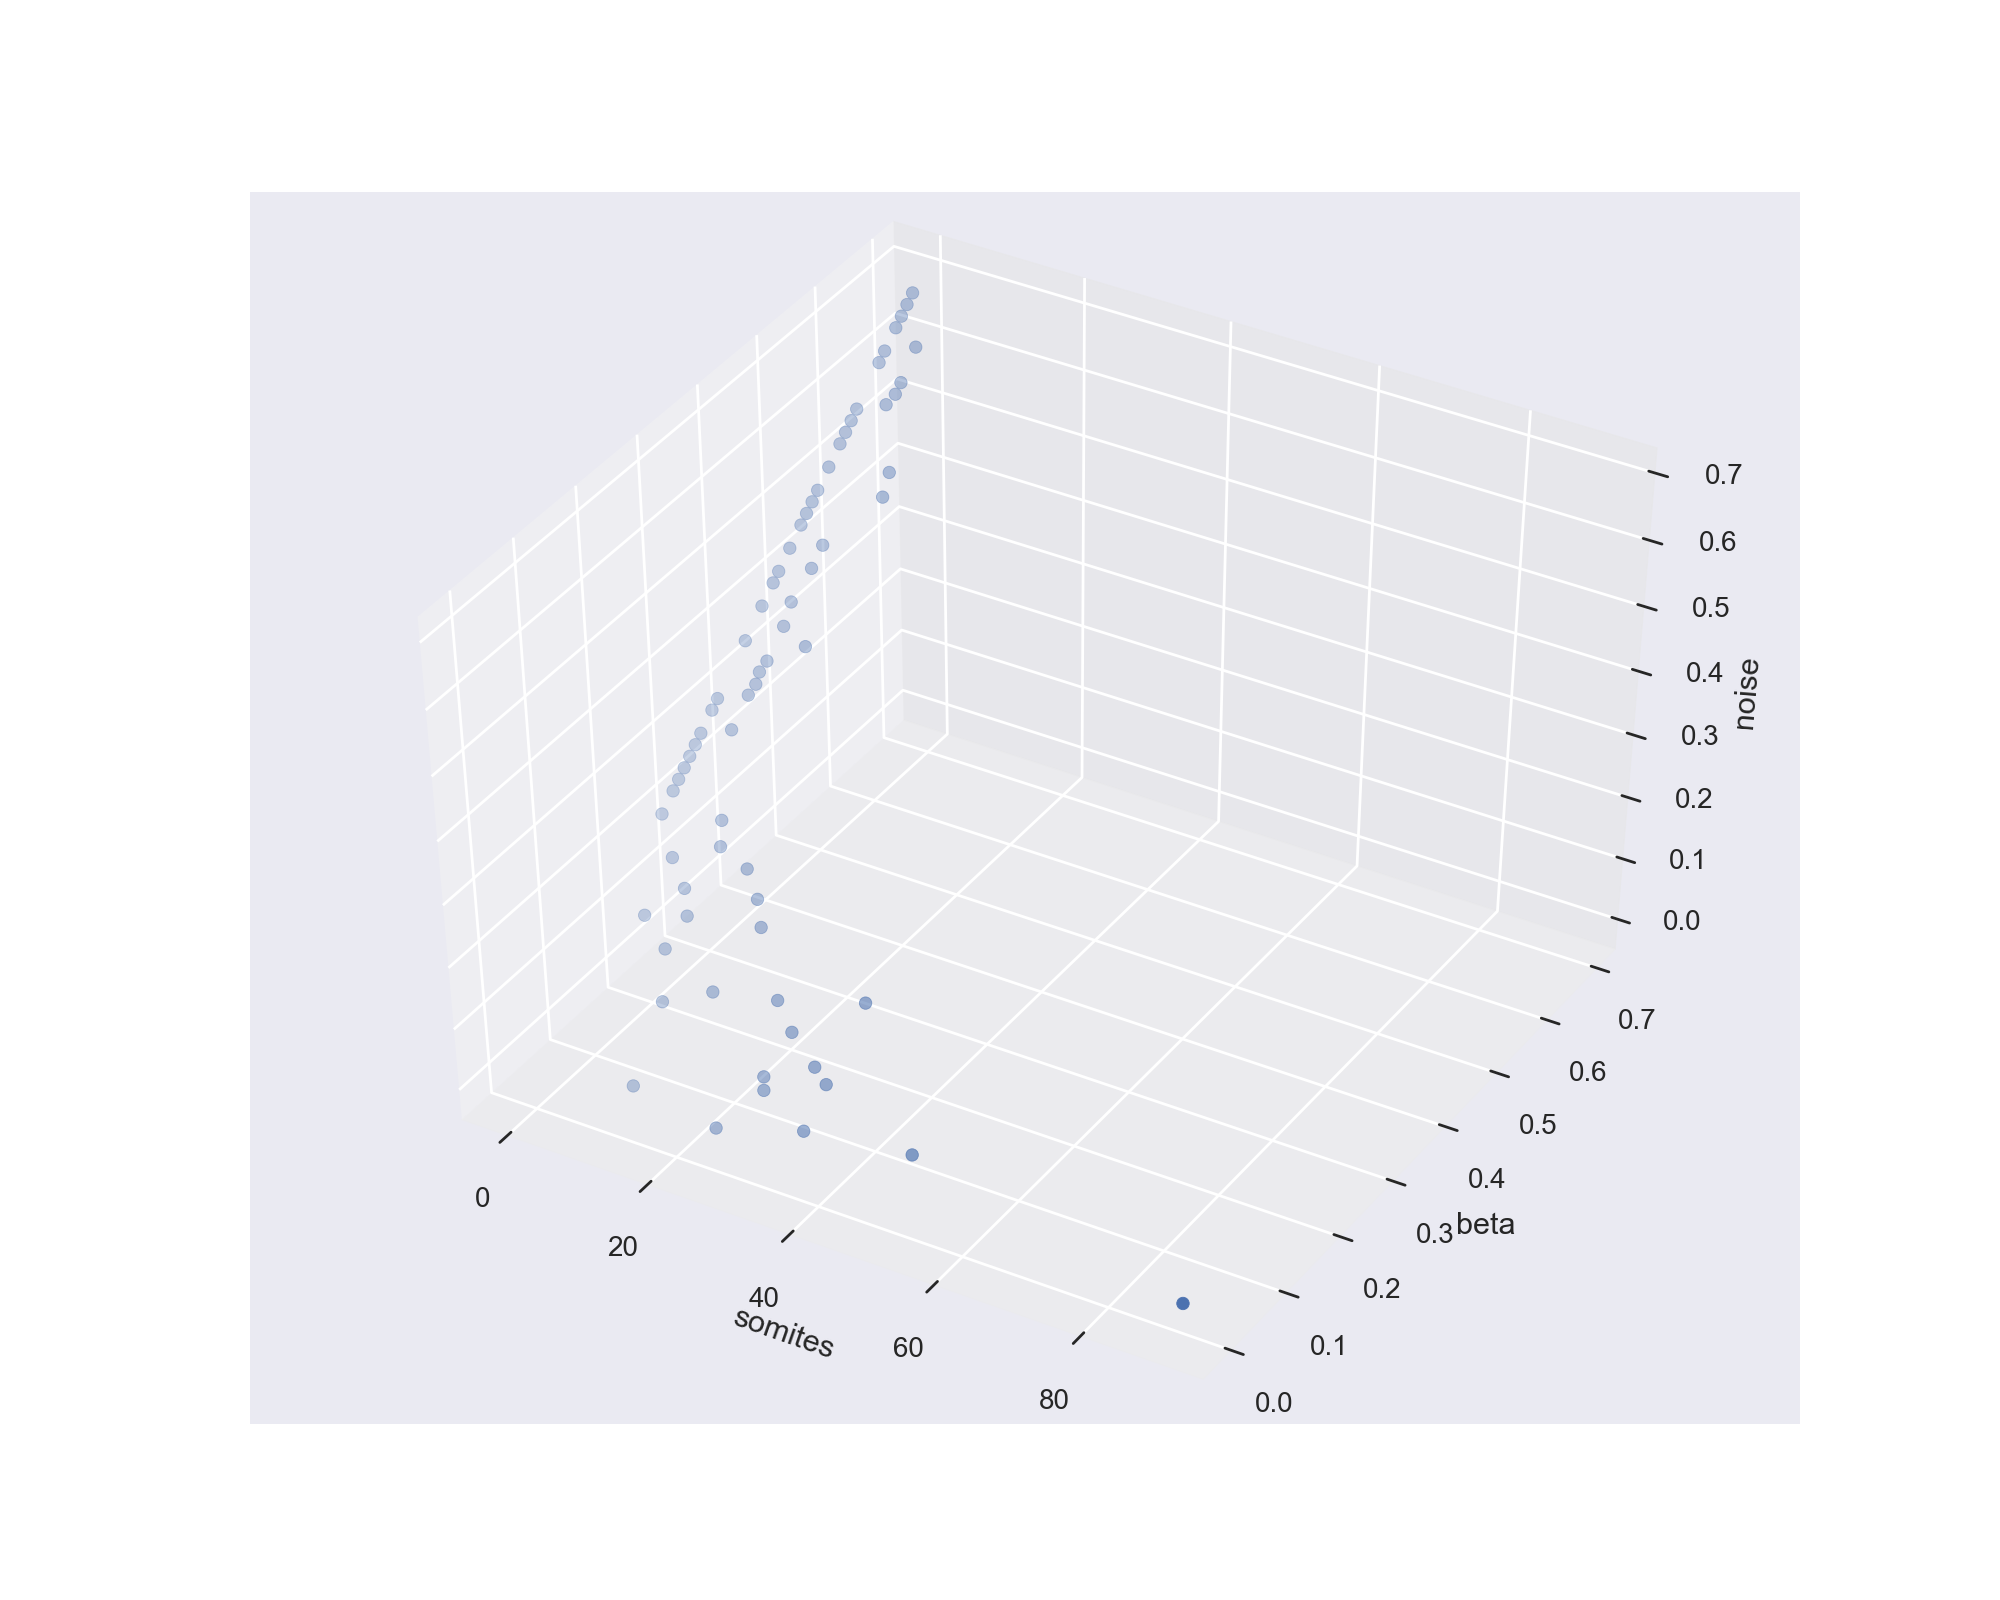

In [81]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("somites")
ax.set_ylabel("beta")
ax.set_zlabel("noise")
ax.scatter(viable_somite_percentage_list, beta[:69], noise[:69])

##### according to the simulations we see that increasing the coupling strength has no significant effect on somite size viability under noisy gene expression 

###### we next explore the effect of noise on the distribution of rmax and rmin 

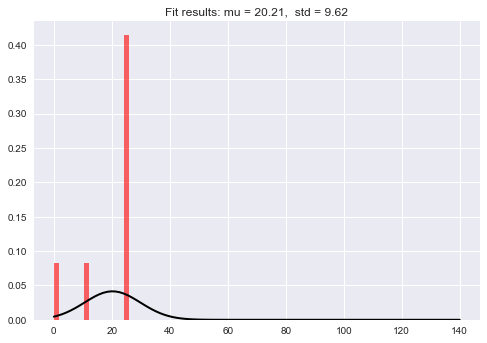

In [191]:
"""mu, std = norm.fit(w_max)
x = np.linspace(0, 140, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.hist(w_max, bins=15, density=True, alpha=0.6, color='r')
plt.show()"""

#### Somite size distribution 

In [95]:
noise  = np.linspace(0, 1, 100)
realizations = 20
u_list_ = []
w_list_ = []
r_list_ = []
for i, n in enumerate(noise):
    u_realizations = []
    w_realizations = []
    r_realizations = []
    for j in range(realizations):
        dic["sigma_1"] = n
        dic["sigma_2"] = n
        u, w, r, h, t, x = run_sim_(dic, coupling= False, noise = True, plot = False, plot_r = False, plot_mollifier=False)
        u_realizations.append(u)
        w_realizations.append(w)
        r_realizations.append(r)
    u_list_.append(u_realizations)
    w_list_.append(w_realizations)
    r_list_.append(r_realizations)

#pickle.dump([u_list, w_list, r_list], open("data_realizations.pkl", "wb"))

stat_list = []
peaks_list = []
dist_list = []
for i, ri in enumerate(r_list_):
        stat_realizations = []
        peaks_realizations = []
        dist_realizations = []
        for j, rr in enumerate(ri):
            try:
                statistics, peaks, dist = extract_somite_statistics_from_readout(rr, dic["dx"])
                stat_realizations.append(statistics)
                peaks_realizations.append(peaks)
                dist_realizations.append(dist)
            except:
                print(i, j)
        stat_list.append(stat_realizations)
        peaks_list.append(peaks_realizations)
        dist_list.append(dist_realizations)

mu_l, std_l = [], []
d_t = []
for d_r in dist_list:
    d_k = []
    for dri in d_r:
        d_k.append(list(dri))
    d_flat = np.asarray([item for sublist in d_k for item in sublist])
    d_t.append(d_flat)
    mu, std = norm.fit(d_flat)
    mu_l.append(mu)
    std_l.append(std)

plt.plot(noise, mu_l)

plt.plot(noise, std_l)

In [153]:
%matplotlib inline 

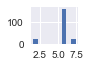

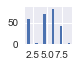

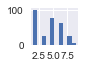

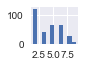

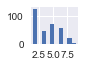

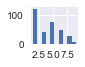

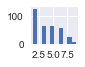

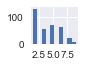

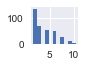

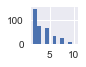

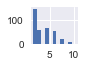

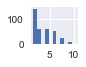

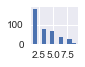

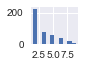

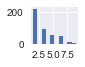

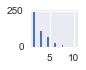

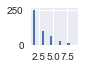

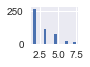

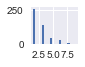

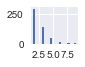

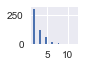

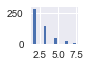

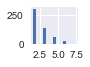

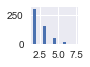

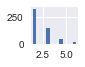

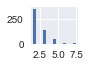

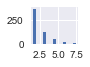

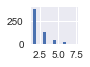

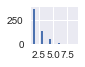

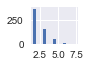

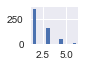

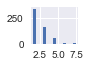

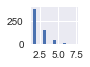

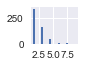

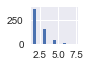

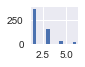

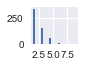

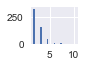

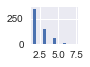

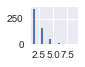

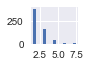

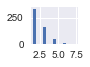

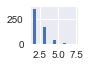

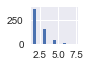

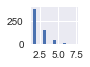

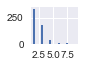

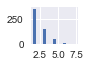

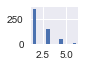

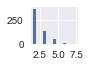

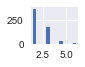

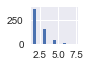

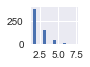

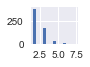

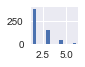

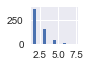

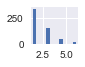

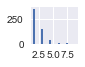

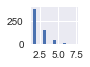

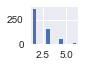

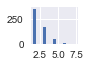

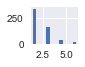

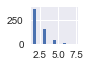

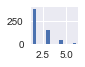

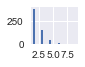

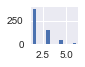

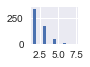

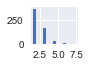

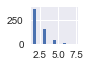

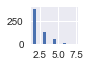

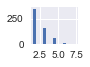

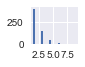

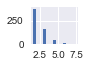

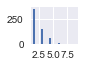

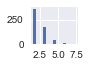

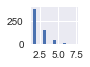

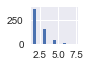

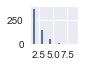

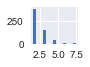

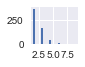

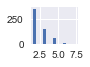

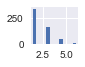

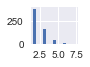

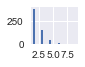

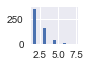

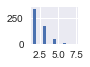

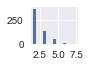

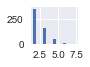

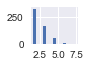

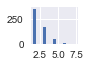

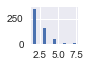

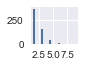

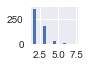

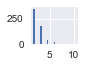

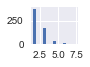

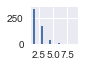

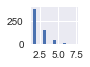

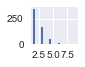

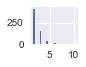

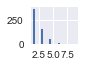

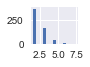

In [156]:
for i in range(1, 101):
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(10,10,i)
    ax.hist(d_t[i-1], bins= "auto")
plt.show()
    

In [ ]:
### with coupling

In [7]:
beta = np.linspace(0, 1, 100)

noise  = np.linspace(0, 1, 100)
realizations = 20
u_list_ = []
w_list_ = []
r_list_ = []
for i, n in enumerate(noise):
    u_realizations = []
    w_realizations = []
    r_realizations = []
    for j in range(realizations):
        dic["sigma_1"] = n
        dic["sigma_2"] = n
        dic["beta"] = beta[i]
        u, w, r, h, t, x = run_sim_(dic, coupling= True, noise = True, plot = False, plot_r = False, plot_mollifier=False)
        u_realizations.append(u)
        w_realizations.append(w)
        r_realizations.append(r)
    u_list_.append(u_realizations)
    w_list_.append(w_realizations)
    r_list_.append(r_realizations)

/Users/ranjak/Downloads/zebra_chord.py:54: RuntimeWarning: overflow encountered in double_scalars
  w2d[cell][i+1] = w2d[cell][i] + dic["dt"]*(-w2d[cell][i]*(1/dic["tau_w"]) + dic["gamma1"]*(u2d[cell][i]**dic["n"]/(u2d[cell][i]**dic["n"]+dic["K_u"]**dic["n"]))*(1/(1+w2d[cell][i-dic["tau_d"]]**dic["m"])) + c + r_w[cell][i])
/Users/ranjak/Downloads/zebra_chord.py:50: RuntimeWarning: overflow encountered in double_scalars
  c = dic["beta"]*(w2d[cell-1][i-dic["tau_c"]]+w2d[cell+1][i-dic["tau_c"]])
/Users/ranjak/Downloads/zebra_chord.py:54: RuntimeWarning: invalid value encountered in double_scalars
  w2d[cell][i+1] = w2d[cell][i] + dic["dt"]*(-w2d[cell][i]*(1/dic["tau_w"]) + dic["gamma1"]*(u2d[cell][i]**dic["n"]/(u2d[cell][i]**dic["n"]+dic["K_u"]**dic["n"]))*(1/(1+w2d[cell][i-dic["tau_d"]]**dic["m"])) + c + r_w[cell][i])


In [9]:
pickle.dump([u_list, w_list, r_list], open("data_realizations.pkl", "wb"))

NameError: name 'u_list' is not defined

In [13]:
stat_list = []
peaks_list = []
dist_list = []
for i, ri in enumerate(r_list_):
        stat_realizations = []
        peaks_realizations = []
        dist_realizations = []
        for j, rr in enumerate(ri):
            try:
                statistics, peaks, dist = extract_somite_statistics_from_readout(rr, dic["dx"])
                stat_realizations.append(statistics)
                peaks_realizations.append(peaks)
                dist_realizations.append(dist)
            except:
                print (i, j)
        stat_list.append(stat_realizations)
        peaks_list.append(peaks_realizations)
        dist_list.append(dist_realizations)

69 0
69 1
69 2
69 3
69 4
69 5
69 6
69 7
69 8
69 9
69 10
69 11
69 12
69 13
69 14
69 15
69 16
69 17
69 18
69 19
70 0
70 1
70 2
70 3
70 4
70 5
70 6
70 7
70 8
70 9
70 10
70 11
70 12
70 13
70 14
70 15
70 16
70 17
70 18
70 19
71 0
71 1
71 2
71 3
71 4
71 5
71 6
71 7
71 8
71 9
71 10
71 11
71 12
71 13
71 14
71 15
71 16
71 17
71 18
71 19
72 0
72 1
72 2
72 3
72 4
72 5
72 6
72 7
72 8
72 9
72 10
72 11
72 12
72 13
72 14
72 15
72 16
72 17
72 18
72 19
73 0
73 1
73 2
73 3
73 4
73 5
73 6
73 7
73 8
73 9
73 10
73 11
73 12
73 13
73 14
73 15
73 16
73 17
73 18
73 19
74 0
74 1
74 2
74 3
74 4
74 5
74 6
74 7
74 8
74 9
74 10
74 11
74 12
74 13
74 14
74 15
74 16
74 17
74 18
74 19
75 0
75 1
75 2
75 3
75 4
75 5
75 6
75 7
75 8
75 9
75 10
75 11
75 12
75 13
75 14
75 15
75 16
75 17
75 18
75 19
76 0
76 1
76 2
76 3
76 4
76 5
76 6
76 7
76 8
76 9
76 10
76 11
76 12
76 13
76 14
76 15
76 16
76 17
76 18
76 19
77 0
77 1
77 2
77 3
77 4
77 5
77 6
77 7
77 8
77 9
77 10
77 11
77 12
77 13
77 14
77 15
77 16
77 17
77 18
77 19
78 0
78 1


In [14]:
mu_l, std_l = [], []
d_t = []
for d_r in dist_list:
    d_k = []
    for dri in d_r:
        d_k.append(list(dri))
    d_flat = np.asarray([item for sublist in d_k for item in sublist])
    d_t.append(d_flat)
    mu, std = norm.fit(d_flat)
    mu_l.append(mu)
    std_l.append(std)

/anaconda3/envs/rem/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:268: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/anaconda3/envs/rem/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/rem/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:273: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


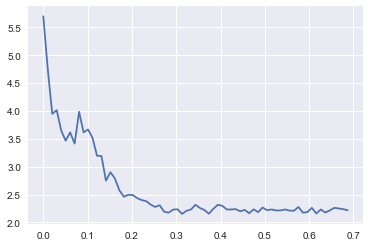

In [16]:

plt.plot(noise[:69], mu_l[:69])

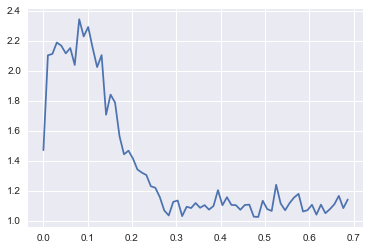

In [17]:
plt.plot(noise[:69], std_l[:69])

In [75]:
u_list[30][30].shape

(4000,)

In [80]:
u[30].shape

(4000,)

In [82]:
spectrum = abs(np.fft.fft((u[30])))**2
freq = np.fft.fftfreq(len(spectrum))


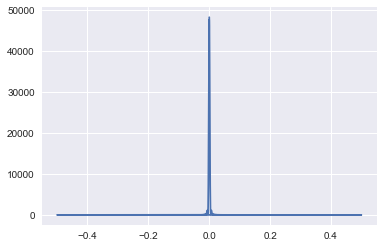

In [83]:
plt.plot(freq, spectrum)